In [1]:
from common import *
from pandas.api.types import CategoricalDtype
import warnings 
warnings.filterwarnings('ignore')
debug = O()
%matplotlib inline
canvas(12,12)

In [2]:
M = pd.read_pickle(top_dir+'data/given/M.pkl')
#N = pd.read_pickle(top_dir+'data/given/N1.pkl')
#test = pd.read_pickle(top_dir+'data/given/test.pkl')

In [7]:
class IdAssign:
    def __init__(self, init):
        self.map = {x: i for i,x in enumerate(init)}
    def __call__(self, key):
        if key not in self.map:
            self.map[key] = len(self.map)
        return self.map[key]

assetCodeSeries = pd.Series(M.assetCode.unique())
numAssetCode = len(assetCodeSeries)
assetCodeIdMap = IdAssign(assetCodeSeries)
#assetCodeIndex = pd.Index(assetCodeSeries)
#assetCodeIndexedDf = assetCodeIndex.to_frame().drop(0,axis=1)

assetNameSeries = pd.Series(M.assetName.unique())
numAssetName = len(assetNameSeries)
#assetNameCategorical = CategoricalDtype(assetNameSeries, ordered=False)
#assetNameSeries = assetNameSeries.astype(assetNameCategorical)
assetNameIdMap = IdAssign(assetNameSeries)
#assetNameIndex = pd.Index(assetNameSeries)
#assetNameIndexedDf = assetNameIndex.to_frame().drop(0,axis=1)

In [19]:
returns_columns = {
    'returnsClosePrevRaw1':'cc', 'returnsOpenPrevRaw1':'oo',
    'returnsClosePrevMktres1':'cc0', 'returnsOpenPrevMktres1':'oo0',
    'returnsClosePrevRaw10':'cc_10','returnsOpenPrevRaw10':'oo_10',
    'returnsClosePrevMktres10':'cc0_10','returnsOpenPrevMktres10':'oo0_10'
}
excluded_columns = [
    'time','assetCode','assetName','universe','returnsOpenNextMktres10','quarter'
]
column_filter = lambda c: c not in returns_columns and c not in excluded_columns
enumeration_columns = ['assetCodeId', 'assetNameId']

In [20]:
train_start_time = pd.Timestamp('2009-01-01',tz='UTC')
shortterm = 21
longterm = 250

In [29]:
def add_basic_features(*,M):
    M['assetCodeId'] = M.assetCode.map(assetCodeIdMap).astype(int)
    M['assetNameId'] = M.assetName.map(assetNameIdMap).astype(int)
    for orig_col, new_col in returns_columns.items():
        M[new_col] = np.log(M[orig_col]+1)
    # time features
    M['dayOfYear'] = M.time.dt.dayofyear
    M['dayOfWeek'] = M.time.dt.dayofweek
    
    gc.collect()

    
def add_shortterm_price_features(*,U,u):
    ################################################################ no NaNs here:
    U['(oo-oo0)_'] = U.oo_ - U.oo0_
    for ww in ['oo','oo0','(oo-oo0)']:
        window = np.flip(U[ww+'_'],axis=0)[:20]
        for c in combos.ckco(20,5):
            name = '{}{{{}}}'.format(ww+'_', combos.name.consec(c))
            u[name] = c@window
    ################################################################# can be NaNs:
    U['(oo-oo0)*'] = U.oo - U.oo0
    U['(cc-cc0)*'] = U.cc - U.cc0
    for ww in ['(oo-oo0)','(cc-cc0)']:
        window = np.flip(U[ww+'*'],axis=0)[:3]
        for c in combos.union(combos.omo(3),combos.mintco(3,1,1)):
            name = '{}{{{}}}'.format(ww, combos.name.index(c))
            if name[-3]=='{0}':
                name = name[:-3]
            u[name] = c@window
    ################################################################# can be NaNs:
    log_open, log_close = np.log(U.open), np.log(U.close) # can be NaNs here
    U['af'] = log_open - np.shift(log_close,1,axis=0)
    U['it'] = log_close - log_open
    u['af{1}'] = U.af[-2]
    u['it{1}'] = U.it[-2]
    
    near0 = np.stack([U.it[-1],U.af[-1],U.it[-2],U.oo0[-1],U.cc0[-1]], axis=0) # can be NaNs
    near1 = np.stack([U.it[-2],U.af[-2],U.it[-3],U.oo0[-2],U.cc0[-2]], axis=0) # can be NaNs
    for c in combos.omo(5):
        name = '(it,af,it{{1}},oo0,cc0){{{}}}'.format(combos.name.index(c))
        u[name] = c@near0
        name = '(it{{1}},af{{1}},it{{2}},oo0{{1}},cc0{{1}}){{{}}}'.format(combos.name.index(c))
        u[name] = c@near1
    ################################################################### NaNsがあるけど……:
    log_volume = np.log(U.volume)
    u['volumeRatioMeanBack2'] = log_volume[-1] - np.log(U.volume[-3:-1].mean(axis=0))
    u['volumeRatioMeanBack2{1}'] = log_volume[-2] - np.log(U.volume[-4:-2].mean(axis=0))
    u['volumeRatioMean5'] = log_volume[-1] - np.log(U.volume[-5:].mean(axis=0))
    u['volumeRatioMean10'] = log_volume[-1] - np.log(U.volume[-10:].mean(axis=0))
    u['volumeRatioMean10{5}'] = log_volume[-6] - np.log(U.volume[-15:-5].mean(axis=0))
    u['volumeRatioMean5ByMean20'] = np.log(U.volume[-5:].mean(axis=0)) - np.log(U.volume[-20:].mean(axis=0))
    
    gc.collect()
            
    
def add_longterm_price_features(*,U,u,horizons=[21,62,125,250]):
    ################################################################# no NaNs
    u['oo0_20'] = U.oo0_10_[-11::10].sum(axis=0)
    u['oo0_60'] = U.oo0_10_[-61::10].sum(axis=0)
    u['oo0_120'] = U.oo0_10_[-121::10].sum(axis=0)
    u['oo0_250'] = U.oo0_10_[-251::10].sum(axis=0)
    
    u['oo_20'] = U.oo_10_[-11::10].sum(axis=0)
    u['oo_60'] = U.oo_10_[-61::10].sum(axis=0)
    u['oo_120'] = U.oo_10_[-121::10].sum(axis=0)
    u['oo_250'] = U.oo_10_[-251::10].sum(axis=0)
    
    u['(oo-oo0)_10'] = U.oo_10[-1] - U.oo0_10[-1]
    u['(oo-oo0)_20'] = U.oo_10_[-11::10].sum(axis=0) - U.oo0_10_[-11::10].sum(axis=0)
    u['(oo-oo0)_60'] = U.oo_10_[-61::10].sum(axis=0) - U.oo0_10_[-61::10].sum(axis=0)
    u['(oo-oo0)_120'] = U.oo_10_[-121::10].sum(axis=0) - U.oo0_10_[-121::10].sum(axis=0)
    u['(oo-oo0)_250'] = U.oo_10_[-251::10].sum(axis=0) - U.oo0_10_[-251::10].sum(axis=0)
    #################################################################### no NaNs
    for ww in ['oo','oo0']:
        for h in horizons:
            strh = str(h)
            since = U[ww+'Since'+strh] = U[ww+'_'][-h:].cumsum(axis=0)
                   
            maxSince = U[ww+'MaxSince'+strh] = np.maximum.accumulate(since, axis=0)
            drawdownSince = U[ww+'DrawdownSince'+strh] = maxSince - since
            u[ww+'MaxDrawdown5Since'+strh] = drawdownSince[-5:].max(axis=0)
            u[ww+'MaxDrawdown10Since'+strh] = drawdownSince[-10:].max(axis=0)
            #u[ww+'MaxDrawdown20Since'+strh] = drawdownSince[-20:].max(axis=0)
            u[ww+'MaxDrawdown(10-5)Since'+strh] = drawdownSince[-10:-5].max(axis=0)
            u[ww+'MaxDrawdown(20-10)Since'+strh] = drawdownSince[-20:-10].max(axis=0)
            u[ww+'Prev5MaxSince'+strh] = maxSince[-6]
            u[ww+'Prev10MaxSince'+strh] = maxSince[-11]
            #u[ww+'Prev20MaxSince'+strh] = maxSince[-21]
            
            minSince = U[ww+'MinSince'+strh] = np.minimum.accumulate(since, axis=0)
            drawupSince = U[ww+'DrawupSince'+strh] = since - minSince
            maxDrawup5Since = U[ww+'MaxDrawup5Since'+strh] = drawupSince[-5:].max(axis=0)[np.newaxis,:]
            maxDrawup10Since = U[ww+'MaxDrawup10Since'+strh] = drawupSince[-10:].max(axis=0)[np.newaxis,:]
            #maxDrawup20Since = U[ww+'MaxDrawup20Since'+strh] = drawupSince[-20:].max(axis=0)[np.newaxis,:]
            maxDrawup10_5Since = U[ww+'MaxDrawup(10-5)Since'+strh] = drawupSince[-10:-5].max(axis=0)[np.newaxis,:]
            maxDrawup20_10Since = U[ww+'MaxDrawup(20-10)Since'+strh] = drawupSince[-20:-10].max(axis=0)[np.newaxis,:]
            u[ww+'Prev5MinSince'+strh] = minSince[-6]
            u[ww+'Prev10MinSince'+strh] = minSince[-11]
            #u[ww+'Prev20MinSince'+strh] = minSince[-21]
            
    gc.collect()


def add_postprocessing_features(*,F):
    F['assetCodeIdWTFlogabs'] = F.assetCodeId.map(str).map(hash).pipe(np.abs).pipe(np.log)
    F['assetCodeIdWTFsin2'] = F.assetCodeId.map(str).map(hash).pipe(np.sin).pipe(lambda x: x * x)
    F['assetCodeIdWTFFlogabs'] = F.assetCodeId.map(str).map(hash).map(str).map(hash).pipe(np.abs).pipe(np.log)
    F['assetCodeIdWTFFsin2'] = F.assetCodeId.map(str).map(hash).map(str).map(hash).pipe(np.sin).pipe(lambda x: x * x)

In [30]:
def make_single_A_U_u(*,M):
    A = M[~M.assetCodeId.isna()] # ditch the unseen assetCodes
    A = pd.DataFrame(index=pd.Series(range(numAssetCode),name='assetCodeId')).join(
        A.set_index('assetCodeId')) # join onto standard assetCode row-index
    V = O(**{c:A[c] for c in A})
    U = O(**{c:df.values[np.newaxis,:] for c,df in dict.items(V) if column_filter(c)},
          **{c+'_':np.nan_to_num(df.values[np.newaxis,:]) for c,df in dict.items(V) if column_filter(c)})
    return A, U, O()
def make_U(*,M):
    Us = [make_single_A_U_u(M=m)[1] for _,m in M.groupby('time')]
    U = O(**{c:np.concatenate([u[c] for u in Us],axis=0) for c in Us[0]})
    return U

In [31]:
Minit = M[M.time<=M.time.unique()[longterm]]
add_basic_features(M=Minit)
Uinit = make_U(M=Minit)
uinit = O()
debug.U0_keys = set(dict.keys(Uinit))
add_shortterm_price_features(U=Uinit,u=uinit)
add_longterm_price_features(U=Uinit,u=uinit)

In [32]:
def iter_features_templates(MNP_iter, *, U_):
    U_tuple = U_
    Mcolumns = list(filter(column_filter, (c for c in Minit.columns if c[-1] not in '*_')))
    Ucolumns = list(filter(column_filter, (str(c) for c in Uinit if c not in Mcolumns and c[-1] not in '*_')))
    ucolumns = [str(c) for c in uinit]
    U_, term = U_tuple
    for M, N, P in MNP_iter:
        orig_index = M.index
        add_basic_features(M=M)
        M0 = pd.DataFrame(index=M.assetCodeId)
        A, U, u = make_single_A_U_u(M=M)
        assert debug.U0_keys==set(dict.keys(U))
        # join new row vectors in U to the old tables in U_ and U__
        for key in U:
            key = str(key)
            U_[key] = np.concatenate([U_[key],U[key]], axis=0)
            if len(U_[key])>term:
                U_[key] = U_[key][-term:]
        # add features to U_ and U__
        gc.collect()
        add_shortterm_price_features(U=U_,u=u)
        gc.collect()
        add_longterm_price_features(U=U_,u=u)
        gc.collect()
        assert len(set(U_)&set(u))==0
        # take out the bottom row of the feature tables to feed out as our feature construction iterator
        _dict = {c:a[-1] for c,a in dict.items(U_)}
        _dict.update({c:a for c,a in dict.items(u)})
        columns = Ucolumns+ucolumns
        F = pd.DataFrame([_dict[c] for c in columns], index=columns, columns=A.index).T
        F = pd.concat([A.reset_index()[Mcolumns],F], axis=1)
        F = M0.join(F)
        F.index = orig_index
        for c in enumeration_columns:
            assert np.issubdtype(F[c].dtype, np.integer)
        add_postprocessing_features(F=F)
        yield F, P

In [33]:
def iter_MNP_train(*,M,N):
    M_, N_ = M, N
    for time, M in M_.groupby('time'):
        if time<train_start_time:
            continue
        M['quarter'] = M.time.dt.year+(M.time.dt.quarter-1)/4
        P = M[excluded_columns]
        M = M.drop(columns=['returnsOpenNextMktres10','quarter'])
        yield M, None, P
        
Mstart = M[M.time<train_start_time]
add_basic_features(M=Mstart)
U_ = make_U(M=Mstart)
u_ = O()
add_shortterm_price_features(U=U_,u=u_)
add_longterm_price_features(U=U_,u=u_)

In [18]:
%%time
def make_train():
    feat_iter = iter_features_templates(iter_MNP_train(M=M,N=None), U_=(U_,longterm))
    train = [[print_progress(i,10),(F,P)][-1] for i,(F,P) in enumerate(feat_iter)]
    F = pd.concat([FP[0] for FP in train], axis=0)
    P = pd.concat([FP[1] for FP in train], axis=0)
    F.index = P.index
    return F,P
F,P = make_train()

0.........100.........200.........300.........400.........500.........600.........700.........800.........900.........1000.........1100.........1200.........1300.........1400.........1500.........1600.........1700.........1800.........1900.........2000.CPU times: user 1h 13min 6s, sys: 2min 34s, total: 1h 15min 41s
Wall time: 27min 41s


In [34]:
#pd.to_pickle((F,P), big_data+'saves/train_1logfirst.pkl')
FF,PP = pd.read_pickle(big_data+'saves/train_1logfirst.pkl')

In [12]:
#pd.to_pickle((F,P), big_data+'saves/train_1really.pkl')
F1,P1 = pd.read_pickle(big_data+'saves/train_thefault.pkl')

In [13]:
#pd.to_pickle((F,P), top_dir+'data/saves/train_extrafault.pkl')
F0,P0 = pd.read_pickle(big_data+'saves/train_newfault.pkl')

In [75]:
for line in F0.columns:
    print(line)

volume
close
open
assetCodeId
assetNameId
cc
oo
cc0
oo0
cc_10
oo_10
cc0_10
oo0_10
dayOfYear
dayOfWeek
af
it
oo{(0..4)^1}
oo{(0..9)^1}
oo{(0..14)^1}
oo{(0..19)^1}
oo{(5..9)^1}
oo{(5..14)^1}
oo{(5..19)^1}
oo{(10..14)^1}
oo{(10..19)^1}
oo{(15..19)^1}
oo0{(0..4)^1}
oo0{(0..9)^1}
oo0{(0..14)^1}
oo0{(0..19)^1}
oo0{(5..9)^1}
oo0{(5..14)^1}
oo0{(5..19)^1}
oo0{(10..14)^1}
oo0{(10..19)^1}
oo0{(15..19)^1}
(it,af,it[1],oo0,cc0){0/1}
(it,af,it[1],oo0,cc0){0/2}
(it,af,it[1],oo0,cc0){0/3}
(it,af,it[1],oo0,cc0){0/4}
(it,af,it[1],oo0,cc0){1/2}
(it,af,it[1],oo0,cc0){1/3}
(it,af,it[1],oo0,cc0){1/4}
(it,af,it[1],oo0,cc0){2/3}
(it,af,it[1],oo0,cc0){2/4}
(it,af,it[1],oo0,cc0){3/4}
oo0_20
ooSince21
ooMaxSince21
ooDrawdownSince21
ooMaxDrawdown5Since21
ooMaxDrawdown10Since21
ooPrev5MaxSince21
ooMinSince21
ooPrev5MinSince21
ooSince62
ooMaxSince62
ooDrawdownSince62
ooMaxDrawdown5Since62
ooMaxDrawdown10Since62
ooPrev5MaxSince62
ooMinSince62
ooPrev5MinSince62
ooSince125
ooMaxSince125
ooDrawdownSince125
ooMaxDrawdo

In [37]:
fNew = set(F0.columns)
fExtra = set(F1.columns)
fExtra-fNew

{'(it,af,it{1},oo,cc,oo0,cc0)*{0,1}{0/10}',
 '(it,af,it{1},oo,cc,oo0,cc0)*{0,1}{0/11}',
 '(it,af,it{1},oo,cc,oo0,cc0)*{0,1}{0/12}',
 '(it,af,it{1},oo,cc,oo0,cc0)*{0,1}{0/13}',
 '(it,af,it{1},oo,cc,oo0,cc0)*{0,1}{0/1}',
 '(it,af,it{1},oo,cc,oo0,cc0)*{0,1}{0/2}',
 '(it,af,it{1},oo,cc,oo0,cc0)*{0,1}{0/3}',
 '(it,af,it{1},oo,cc,oo0,cc0)*{0,1}{0/4}',
 '(it,af,it{1},oo,cc,oo0,cc0)*{0,1}{0/5}',
 '(it,af,it{1},oo,cc,oo0,cc0)*{0,1}{0/6}',
 '(it,af,it{1},oo,cc,oo0,cc0)*{0,1}{0/7}',
 '(it,af,it{1},oo,cc,oo0,cc0)*{0,1}{0/8}',
 '(it,af,it{1},oo,cc,oo0,cc0)*{0,1}{0/9}',
 '(it,af,it{1},oo,cc,oo0,cc0)*{0,1}{1/10}',
 '(it,af,it{1},oo,cc,oo0,cc0)*{0,1}{1/11}',
 '(it,af,it{1},oo,cc,oo0,cc0)*{0,1}{1/12}',
 '(it,af,it{1},oo,cc,oo0,cc0)*{0,1}{1/13}',
 '(it,af,it{1},oo,cc,oo0,cc0)*{0,1}{1/2}',
 '(it,af,it{1},oo,cc,oo0,cc0)*{0,1}{1/3}',
 '(it,af,it{1},oo,cc,oo0,cc0)*{0,1}{1/4}',
 '(it,af,it{1},oo,cc,oo0,cc0)*{0,1}{1/5}',
 '(it,af,it{1},oo,cc,oo0,cc0)*{0,1}{1/6}',
 '(it,af,it{1},oo,cc,oo0,cc0)*{0,1}{1/7}',
 '(

### LightGBM

In [35]:
F,P = FF,PP

In [36]:
from sklearn.model_selection import GroupShuffleSplit

ho = P.quarter>=2015.5
ho.name = None
tr, cv = next(GroupShuffleSplit(n_splits=1, test_size=.5, random_state=44).split(F[~ho], P[~ho], groups=P[~ho].quarter))
_dummy = pd.Series(range(len(P)),index=P.index)
tr, cv = _dummy.isin(tr), _dummy.isin(cv)

In [37]:
P['target'] = P.returnsOpenNextMktres10>0
P['upDown'] = (P.target*2-1)
P['upDown1'] = P.upDown*P.universe.astype(int)
P['absVal'] = np.abs(P.returnsOpenNextMktres10)
P['absVal1'] = P.absVal*P.universe
P['weight'] = P.absVal#.qtl()
P['weight1'] = P.weight*P.universe

In [38]:
fThefault = ["volume","close","open","assetCodeId","assetNameId","cc","oo","cc0","oo0","cc_10","oo_10","cc0_10","oo0_10","dayOfYear","dayOfWeek","af","it","ooSince21","ooMaxSince21","ooDrawdownSince21","ooMinSince21","ooDrawupSince21","ooMaxDrawup5Since21","ooMaxDrawup10Since21","ooMaxDrawup(10-5)Since21","ooMaxDrawup(20-10)Since21","ooSince62","ooMaxSince62","ooDrawdownSince62","ooMinSince62","ooDrawupSince62","ooMaxDrawup5Since62","ooMaxDrawup10Since62","ooMaxDrawup(10-5)Since62","ooMaxDrawup(20-10)Since62","ooSince125","ooMaxSince125","ooDrawdownSince125","ooMinSince125","ooDrawupSince125","ooMaxDrawup5Since125","ooMaxDrawup10Since125","ooMaxDrawup(10-5)Since125","ooMaxDrawup(20-10)Since125","ooSince250","ooMaxSince250","ooDrawdownSince250","ooMinSince250","ooDrawupSince250","ooMaxDrawup5Since250","ooMaxDrawup10Since250","ooMaxDrawup(10-5)Since250","ooMaxDrawup(20-10)Since250","oo0Since21","oo0MaxSince21","oo0DrawdownSince21","oo0MinSince21","oo0DrawupSince21","oo0MaxDrawup5Since21","oo0MaxDrawup10Since21","oo0MaxDrawup(10-5)Since21","oo0MaxDrawup(20-10)Since21","oo0Since62","oo0MaxSince62","oo0DrawdownSince62","oo0MinSince62","oo0DrawupSince62","oo0MaxDrawup5Since62","oo0MaxDrawup10Since62","oo0MaxDrawup(10-5)Since62","oo0MaxDrawup(20-10)Since62","oo0Since125","oo0MaxSince125","oo0DrawdownSince125","oo0MinSince125","oo0DrawupSince125","oo0MaxDrawup5Since125","oo0MaxDrawup10Since125","oo0MaxDrawup(10-5)Since125","oo0MaxDrawup(20-10)Since125","oo0Since250","oo0MaxSince250","oo0DrawdownSince250","oo0MinSince250","oo0DrawupSince250","oo0MaxDrawup5Since250","oo0MaxDrawup10Since250","oo0MaxDrawup(10-5)Since250","oo0MaxDrawup(20-10)Since250","oo_{(0..4)^1}","oo_{(0..9)^1}","oo_{(0..14)^1}","oo_{(0..19)^1}","oo_{(5..9)^1}","oo_{(5..14)^1}","oo_{(5..19)^1}","oo_{(10..14)^1}","oo_{(10..19)^1}","oo_{(15..19)^1}","oo0_{(0..4)^1}","oo0_{(0..9)^1}","oo0_{(0..14)^1}","oo0_{(0..19)^1}","oo0_{(5..9)^1}","oo0_{(5..14)^1}","oo0_{(5..19)^1}","oo0_{(10..14)^1}","oo0_{(10..19)^1}","oo0_{(15..19)^1}","(oo-oo0)_{(0..4)^1}","(oo-oo0)_{(0..9)^1}","(oo-oo0)_{(0..14)^1}","(oo-oo0)_{(0..19)^1}","(oo-oo0)_{(5..9)^1}","(oo-oo0)_{(5..14)^1}","(oo-oo0)_{(5..19)^1}","(oo-oo0)_{(10..14)^1}","(oo-oo0)_{(10..19)^1}","(oo-oo0)_{(15..19)^1}","(oo-oo0){0/1}","(oo-oo0){0/2}","(oo-oo0){1/2}","(oo-oo0){0}","(oo-oo0){1}","(oo-oo0){2}","(cc-cc0){0/1}","(cc-cc0){0/2}","(cc-cc0){1/2}","(cc-cc0){0}","(cc-cc0){1}","(cc-cc0){2}","af{1}","it{1}","(it,af,it{1},oo0,cc0){0/1}","(it{1},af{1},it{2},oo0{1},cc0{1}){0/1}","(it,af,it{1},oo0,cc0){0/2}","(it{1},af{1},it{2},oo0{1},cc0{1}){0/2}","(it,af,it{1},oo0,cc0){0/3}","(it{1},af{1},it{2},oo0{1},cc0{1}){0/3}","(it,af,it{1},oo0,cc0){0/4}","(it{1},af{1},it{2},oo0{1},cc0{1}){0/4}","(it,af,it{1},oo0,cc0){1/2}","(it{1},af{1},it{2},oo0{1},cc0{1}){1/2}","(it,af,it{1},oo0,cc0){1/3}","(it{1},af{1},it{2},oo0{1},cc0{1}){1/3}","(it,af,it{1},oo0,cc0){1/4}","(it{1},af{1},it{2},oo0{1},cc0{1}){1/4}","(it,af,it{1},oo0,cc0){2/3}","(it{1},af{1},it{2},oo0{1},cc0{1}){2/3}","(it,af,it{1},oo0,cc0){2/4}","(it{1},af{1},it{2},oo0{1},cc0{1}){2/4}","(it,af,it{1},oo0,cc0){3/4}","(it{1},af{1},it{2},oo0{1},cc0{1}){3/4}","volumeRatioMeanBack2","volumeRatioMeanBack2{1}","volumeRatioMean5","volumeRatioMean10","volumeRatioMean10{5}","volumeRatioMean5ByMean20","oo0_20","oo0_60","oo0_120","oo0_250","ooMaxDrawdown5Since21","ooMaxDrawdown10Since21","ooMaxDrawdown(10-5)Since21","ooMaxDrawdown(20-10)Since21","ooPrev5MaxSince21","ooPrev10MaxSince21","ooPrev5MinSince21","ooPrev10MinSince21","ooMaxDrawdown5Since62","ooMaxDrawdown10Since62","ooMaxDrawdown(10-5)Since62","ooMaxDrawdown(20-10)Since62","ooPrev5MaxSince62","ooPrev10MaxSince62","ooPrev5MinSince62","ooPrev10MinSince62","ooMaxDrawdown5Since125","ooMaxDrawdown10Since125","ooMaxDrawdown(10-5)Since125","ooMaxDrawdown(20-10)Since125","ooPrev5MaxSince125","ooPrev10MaxSince125","ooPrev5MinSince125","ooPrev10MinSince125","ooMaxDrawdown5Since250","ooMaxDrawdown10Since250","ooMaxDrawdown(10-5)Since250","ooMaxDrawdown(20-10)Since250","ooPrev5MaxSince250","ooPrev10MaxSince250","ooPrev5MinSince250","ooPrev10MinSince250","oo0MaxDrawdown5Since21","oo0MaxDrawdown10Since21","oo0MaxDrawdown(10-5)Since21","oo0MaxDrawdown(20-10)Since21","oo0Prev5MaxSince21","oo0Prev10MaxSince21","oo0Prev5MinSince21","oo0Prev10MinSince21","oo0MaxDrawdown5Since62","oo0MaxDrawdown10Since62","oo0MaxDrawdown(10-5)Since62","oo0MaxDrawdown(20-10)Since62","oo0Prev5MaxSince62","oo0Prev10MaxSince62","oo0Prev5MinSince62","oo0Prev10MinSince62","oo0MaxDrawdown5Since125","oo0MaxDrawdown10Since125","oo0MaxDrawdown(10-5)Since125","oo0MaxDrawdown(20-10)Since125","oo0Prev5MaxSince125","oo0Prev10MaxSince125","oo0Prev5MinSince125","oo0Prev10MinSince125","oo0MaxDrawdown5Since250","oo0MaxDrawdown10Since250","oo0MaxDrawdown(10-5)Since250","oo0MaxDrawdown(20-10)Since250","oo0Prev5MaxSince250","oo0Prev10MaxSince250","oo0Prev5MinSince250","oo0Prev10MinSince250"]

In [39]:
fNewfault0 = ["volume","close","open","assetCodeId","assetNameId","cc","oo","cc0","oo0","cc_10","oo_10","cc0_10","oo0_10","dayOfYear","dayOfWeek","af","it","ooSince21","ooMaxSince21","ooDrawdownSince21","ooMaxDrawdown5Since21","ooMaxDrawdown10Since21","ooPrev10MaxSince21","ooMinSince21","ooPrev10MinSince21","ooSince62","ooMaxSince62","ooDrawdownSince62","ooMaxDrawdown5Since62","ooMaxDrawdown10Since62","ooPrev10MaxSince62","ooMinSince62","ooPrev10MinSince62","ooSince125","ooMaxSince125","ooDrawdownSince125","ooMaxDrawdown5Since125","ooMaxDrawdown10Since125","ooPrev10MaxSince125","ooMinSince125","ooPrev10MinSince125","ooSince250","ooMaxSince250","ooDrawdownSince250","ooMaxDrawdown5Since250","ooMaxDrawdown10Since250","ooPrev10MaxSince250","ooMinSince250","ooPrev10MinSince250","oo0Since21","oo0MaxSince21","oo0DrawdownSince21","oo0MaxDrawdown5Since21","oo0MaxDrawdown10Since21","oo0Prev10MaxSince21","oo0MinSince21","oo0Prev10MinSince21","oo0Since62","oo0MaxSince62","oo0DrawdownSince62","oo0MaxDrawdown5Since62","oo0MaxDrawdown10Since62","oo0Prev10MaxSince62","oo0MinSince62","oo0Prev10MinSince62","oo0Since125","oo0MaxSince125","oo0DrawdownSince125","oo0MaxDrawdown5Since125","oo0MaxDrawdown10Since125","oo0Prev10MaxSince125","oo0MinSince125","oo0Prev10MinSince125","oo0Since250","oo0MaxSince250","oo0DrawdownSince250","oo0MaxDrawdown5Since250","oo0MaxDrawdown10Since250","oo0Prev10MaxSince250","oo0MinSince250","oo0Prev10MinSince250","oo_{(0..4)^1}","oo_{(0..9)^1}","oo_{(0..14)^1}","oo_{(0..19)^1}","oo_{(5..9)^1}","oo_{(5..14)^1}","oo_{(5..19)^1}","oo_{(10..14)^1}","oo_{(10..19)^1}","oo_{(15..19)^1}","oo0_{(0..4)^1}","oo0_{(0..9)^1}","oo0_{(0..14)^1}","oo0_{(0..19)^1}","oo0_{(5..9)^1}","oo0_{(5..14)^1}","oo0_{(5..19)^1}","oo0_{(10..14)^1}","oo0_{(10..19)^1}","oo0_{(15..19)^1}","(it,af,it{1},oo0,cc0){0/1}","(it,af,it{1},oo0,cc0){0/2}","(it,af,it{1},oo0,cc0){0/3}","(it,af,it{1},oo0,cc0){0/4}","(it,af,it{1},oo0,cc0){1/2}","(it,af,it{1},oo0,cc0){1/3}","(it,af,it{1},oo0,cc0){1/4}","(it,af,it{1},oo0,cc0){2/3}","(it,af,it{1},oo0,cc0){2/4}","(it,af,it{1},oo0,cc0){3/4}"]

In [40]:
fNewfault = ["volume","close","open","assetCodeId","assetNameId","cc","oo","cc0","oo0","cc_10","oo_10","cc0_10","oo0_10","dayOfYear","dayOfWeek","ooSince21","ooMaxSince21","ooDrawdownSince21","ooMaxDrawdown5Since21","ooMaxDrawdown10Since21","ooPrev10MaxSince21","ooMinSince21","ooPrev10MinSince21","ooSince62","ooMaxSince62","ooDrawdownSince62","ooMaxDrawdown5Since62","ooMaxDrawdown10Since62","ooPrev10MaxSince62","ooMinSince62","ooPrev10MinSince62","ooSince125","ooMaxSince125","ooDrawdownSince125","ooMaxDrawdown5Since125","ooMaxDrawdown10Since125","ooPrev10MaxSince125","ooMinSince125","ooPrev10MinSince125","ooSince250","ooMaxSince250","ooDrawdownSince250","ooMaxDrawdown5Since250","ooMaxDrawdown10Since250","ooPrev10MaxSince250","ooMinSince250","ooPrev10MinSince250","oo0Since21","oo0MaxSince21","oo0DrawdownSince21","oo0MaxDrawdown5Since21","oo0MaxDrawdown10Since21","oo0Prev10MaxSince21","oo0MinSince21","oo0Prev10MinSince21","oo0Since62","oo0MaxSince62","oo0DrawdownSince62","oo0MaxDrawdown5Since62","oo0MaxDrawdown10Since62","oo0Prev10MaxSince62","oo0MinSince62","oo0Prev10MinSince62","oo0Since125","oo0MaxSince125","oo0DrawdownSince125","oo0MaxDrawdown5Since125","oo0MaxDrawdown10Since125","oo0Prev10MaxSince125","oo0MinSince125","oo0Prev10MinSince125","oo0Since250","oo0MaxSince250","oo0DrawdownSince250","oo0MaxDrawdown5Since250","oo0MaxDrawdown10Since250","oo0Prev10MaxSince250","oo0MinSince250","oo0Prev10MinSince250","oo_{(0..4)^1}","oo_{(0..9)^1}","oo_{(0..14)^1}","oo_{(0..19)^1}","oo_{(5..9)^1}","oo_{(5..14)^1}","oo_{(5..19)^1}","oo_{(10..14)^1}","oo_{(10..19)^1}","oo_{(15..19)^1}","oo0_{(0..4)^1}","oo0_{(0..9)^1}","oo0_{(0..14)^1}","oo0_{(0..19)^1}","oo0_{(5..9)^1}","oo0_{(5..14)^1}","oo0_{(5..19)^1}","oo0_{(10..14)^1}","oo0_{(10..19)^1}","oo0_{(15..19)^1}","(it,af,it{1},oo0,cc0){3/4}"]

In [110]:
L = O()
fTime = 'dayOfYear dayOfWeek'.split()
fAsset = 'assetCodeId assetNameId'.split()
fPriceAbsolute = 'close open'.split()
def select_relative(f):
    return f not in set(fTime+fAsset+fPriceAbsolute)
fSelection = list(filter(select_relative, fNewfault))
F['assetCodeIdWTFlogabs'] = F.assetCodeId.map(str).map(hash).pipe(np.abs).pipe(np.log)
F['assetCodeIdWTFsin2'] = F.assetCodeId.map(str).map(hash).pipe(np.sin).pipe(lambda x: x * x)
F['assetCodeIdWTFFlogabs'] = F.assetCodeId.map(str).map(hash).map(str).map(hash).pipe(np.abs).pipe(np.log)
F['assetCodeIdWTFFsin2'] = F.assetCodeId.map(str).map(hash).map(str).map(hash).pipe(np.sin).pipe(lambda x: x * x)

F_ = F[fSelection+['assetCodeIdWTFFlogabs','assetCodeIdWTFFsin2']]

lgb_data_info = dict(
    feature_name = list(F_.columns),
    categorical_feature = list(F_.dtypes[F_.dtypes==np.int64].index),
    free_raw_data = False,
)
L.tr = lgb.Dataset(F_[tr], P.target[tr], weight=P.weight1[tr], **lgb_data_info)
L.cv = lgb.Dataset(F_[cv], P.target[cv], reference=L.tr, weight=P.weight1[cv], **lgb_data_info)
L.ho = lgb.Dataset(F_[ho], P.target[ho], weight=P.weight1[ho], **lgb_data_info)

In [61]:
L.tr.timeFactor = P.time[tr].factorize()[0]
L.cv.timeFactor = P.time[cv].factorize()[0]
L.tr.value = (P.upDown1*P.absVal1)[tr]
L.cv.value = (P.upDown1*P.absVal1)[cv]
L.tr.i = 0
L.cv.i = 0

def lgb_kaggle_metric(preds, valid_data):
    df_time = valid_data.timeFactor
    #labels = valid_data.get_label()
    values = valid_data.value
    #assert len(labels) == len(df_time)

    preds = preds*2-1
    #labels = labels*2-1
    x_t = preds * values
    
    # Here we take advantage of the fact that `labels` (used to calculate `x_t`)
    # is a pd.Series and call `group_by`
    x_t_sum = x_t.groupby(df_time).sum()
    score = x_t_sum.mean() / x_t_sum.std()

    valid_data.i += lgb_kaggle_metric.hack
    return 'kaggle', score+valid_data.i, True
lgb_kaggle_metric.hack = 0

In [75]:
lgb_params = dict(
    #task = 'train',
    objective = 'binary',
    
    num_iterations = 500,
    early_stopping_round = 50,
    
    learning_rate = .05, #.02, #0.05,
    num_leaves = 1<<12, #1<<16, #1<<12,
    max_depth = 12, #16, #12,
    min_data_in_leaf = 150, #120, #200(rd26)/120(rd17), #150,
    min_sum_hessian_in_leaf = 50, #0, #50,
    #bagging_fraction = 1,
    #bagging_freq = 0,
    #feature_fraction = 1,
    lambda_l1 = .01, #.0, #0.01,
    lambda_l2 = .01, #.0, #0.01,
    min_gain_to_split = 0,
    
    #min_data_per_group = 100,
    #max_cat_threshold = 32,
    #cat_l2 = 10.0,
    #cat_smooth = 10.0,
    #max_cat_to_onehot = 4,
    
    #max_bin = 255,
    
    metric = 'None',
    
    seed = 44, # Change for better luck! :)
    bagging_seed = 45,
    feature_fraction_seed = 46,
    #data_random_seed = 1,
)

evals_result = {}
lgb_model = lgb.train(lgb_params, L.tr, valid_sets=[L.tr,L.cv], valid_names=['tr','cv'],
              feval=lgb_kaggle_metric, evals_result=evals_result, verbose_eval=10)


df_result = pd.DataFrame(evals_result['cv'])

Training until validation scores don't improve for 50 rounds.
[10]	tr's kaggle: 0.651634	cv's kaggle: 0.587583
[20]	tr's kaggle: 0.674249	cv's kaggle: 0.621727
[30]	tr's kaggle: 0.691766	cv's kaggle: 0.626201
[40]	tr's kaggle: 0.712633	cv's kaggle: 0.642692
[50]	tr's kaggle: 0.725668	cv's kaggle: 0.651323
[60]	tr's kaggle: 0.732937	cv's kaggle: 0.655442
[70]	tr's kaggle: 0.736745	cv's kaggle: 0.662042
[80]	tr's kaggle: 0.74059	cv's kaggle: 0.663132
[90]	tr's kaggle: 0.747102	cv's kaggle: 0.669544
[100]	tr's kaggle: 0.754907	cv's kaggle: 0.670985
[110]	tr's kaggle: 0.76182	cv's kaggle: 0.67305
[120]	tr's kaggle: 0.768752	cv's kaggle: 0.674153
[130]	tr's kaggle: 0.77319	cv's kaggle: 0.674137
[140]	tr's kaggle: 0.777543	cv's kaggle: 0.675831
[150]	tr's kaggle: 0.783505	cv's kaggle: 0.676608
[160]	tr's kaggle: 0.785936	cv's kaggle: 0.677794
[170]	tr's kaggle: 0.791206	cv's kaggle: 0.678241
[180]	tr's kaggle: 0.794715	cv's kaggle: 0.677438
[190]	tr's kaggle: 0.80419	cv's kaggle: 0.678393
[2

In [76]:
for ds, metrics in evals_result.items():
    for m_name, m_list in metrics.items():
        if m_name=='kaggle':
            for i,m in enumerate(m_list):
                m_list[i] = m % (lgb_kaggle_metric.hack or 1e6)
        else:
            for i,m in enumerate(m_list):
                m_list[i] *= -1

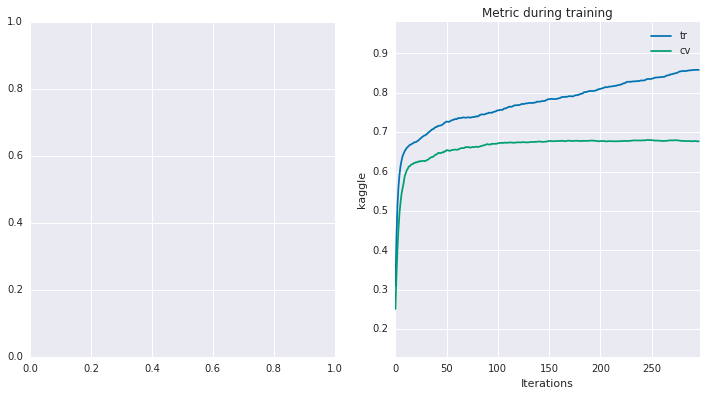

In [77]:
canvas(12,6)
fig, (ax0, ax1) = plt.subplots(1,2)
#ax = lgb.plot_metric(evals_result, metric='binary_logloss', ax=ax0);
ax = lgb.plot_metric(evals_result, metric='kaggle', ax=ax1);
canvas(12,12)

In [209]:
P['model'] = bigGuess*.0+smlGuess*.9 #lgb_model.predict(F_)*2-1

In [210]:
P['guess'] = P.model
P.guess = P.guess*(np.abs(P.guess)>=0.0)

In [211]:
# ideal impossible strategies
#dayguess = P.groupby('time').apply(lambda p: ((p.upDown*p.absVal).sum()>0)*2-1)
#P.guess = P.time.map(dayguess)

In [212]:
P['trade'] = P.guess*P.upDown1*P.absVal1

0.6805255860935218


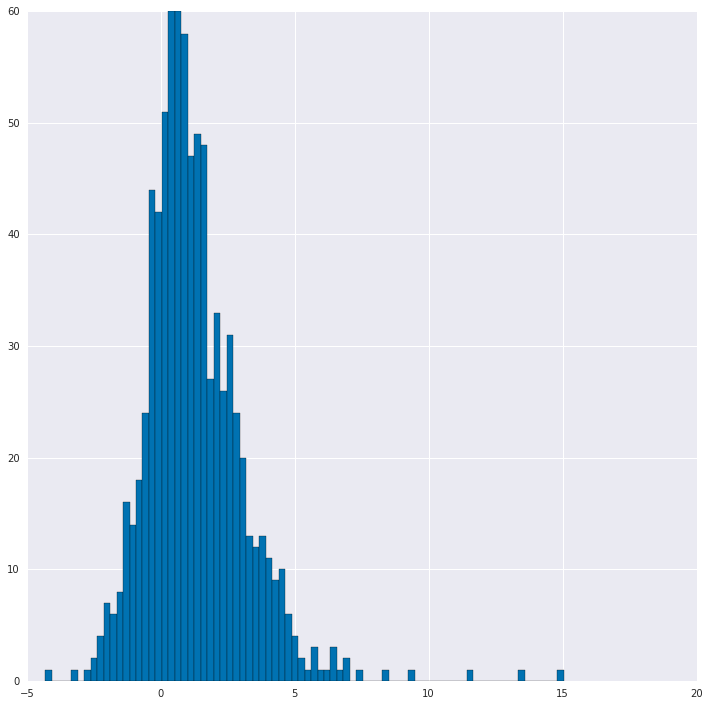

In [213]:
daily = P[cv].groupby('time').trade.sum()
print(daily.mean()/daily.std(ddof=0))
plt.hist(daily, bins=80);

In [83]:
modstr = lgb_model.model_to_string()

In [148]:
grbg = lgb.Booster(train_set=L.tr).model_from_string(bigBst.model_to_string())

Finished loading model, total used 18 iterations


In [147]:
modstrThefault = modstrNewfault
del modstrNewfault

In [152]:
grbg.feature_name().__len__()

221

In [135]:
smlGuess = smlBst.predict(smlF_) * 2 - 1

In [87]:
bigBst = lgb.Booster(train_set=L.tr).model_from_string(modstrThefault)

Finished loading model, total used 18 iterations


In [102]:
bigGuess = bigBst.predict(bigF_) * 2 - 1

In [109]:
assert list(bigF_.columns)==bigBst.feature_name()

In [115]:
smlLoadedBst = lgb.Booster(train_set=L.tr).model_from_string(smlBst.model_to_string())

Finished loading model, total used 247 iterations


In [119]:
smlLoadedGuess = smlLoadedBst.predict(smlF_) * 2 - 1

In [73]:
8070 6696 6174 log @1
7696 6640 6214 sin @1
8132 6670 6305 combine @1
8054 6669 6250 combine @2
7837 6621 6153 combine @1 log @1
8367 6617 6288 combine @2 sin @1
8429 6656 6287 combine @1 @2

SyntaxError: invalid syntax (<ipython-input-73-57b519fda980>, line 1)

In [ ]:
raise Stop()

In [ ]:
{
    2: 0.6168541885774534
    5: 0.6224710382873514,
    10: 0.6056370425353168,
    50: 0.6174873801629851, # better CV though, and overfits TR less
    100: 0.6108589386807013,
}

In [171]:
{
    50: 0.5905464091533569,
    10: 0.5943043430879086,
    5: 0.594418925891397,
    2: 0.5926460860469429,
    0: 0.586289632381248,
    
}

SyntaxError: invalid syntax (<ipython-input-171-291e6a0d00ad>, line 5)

tryfault aggressive


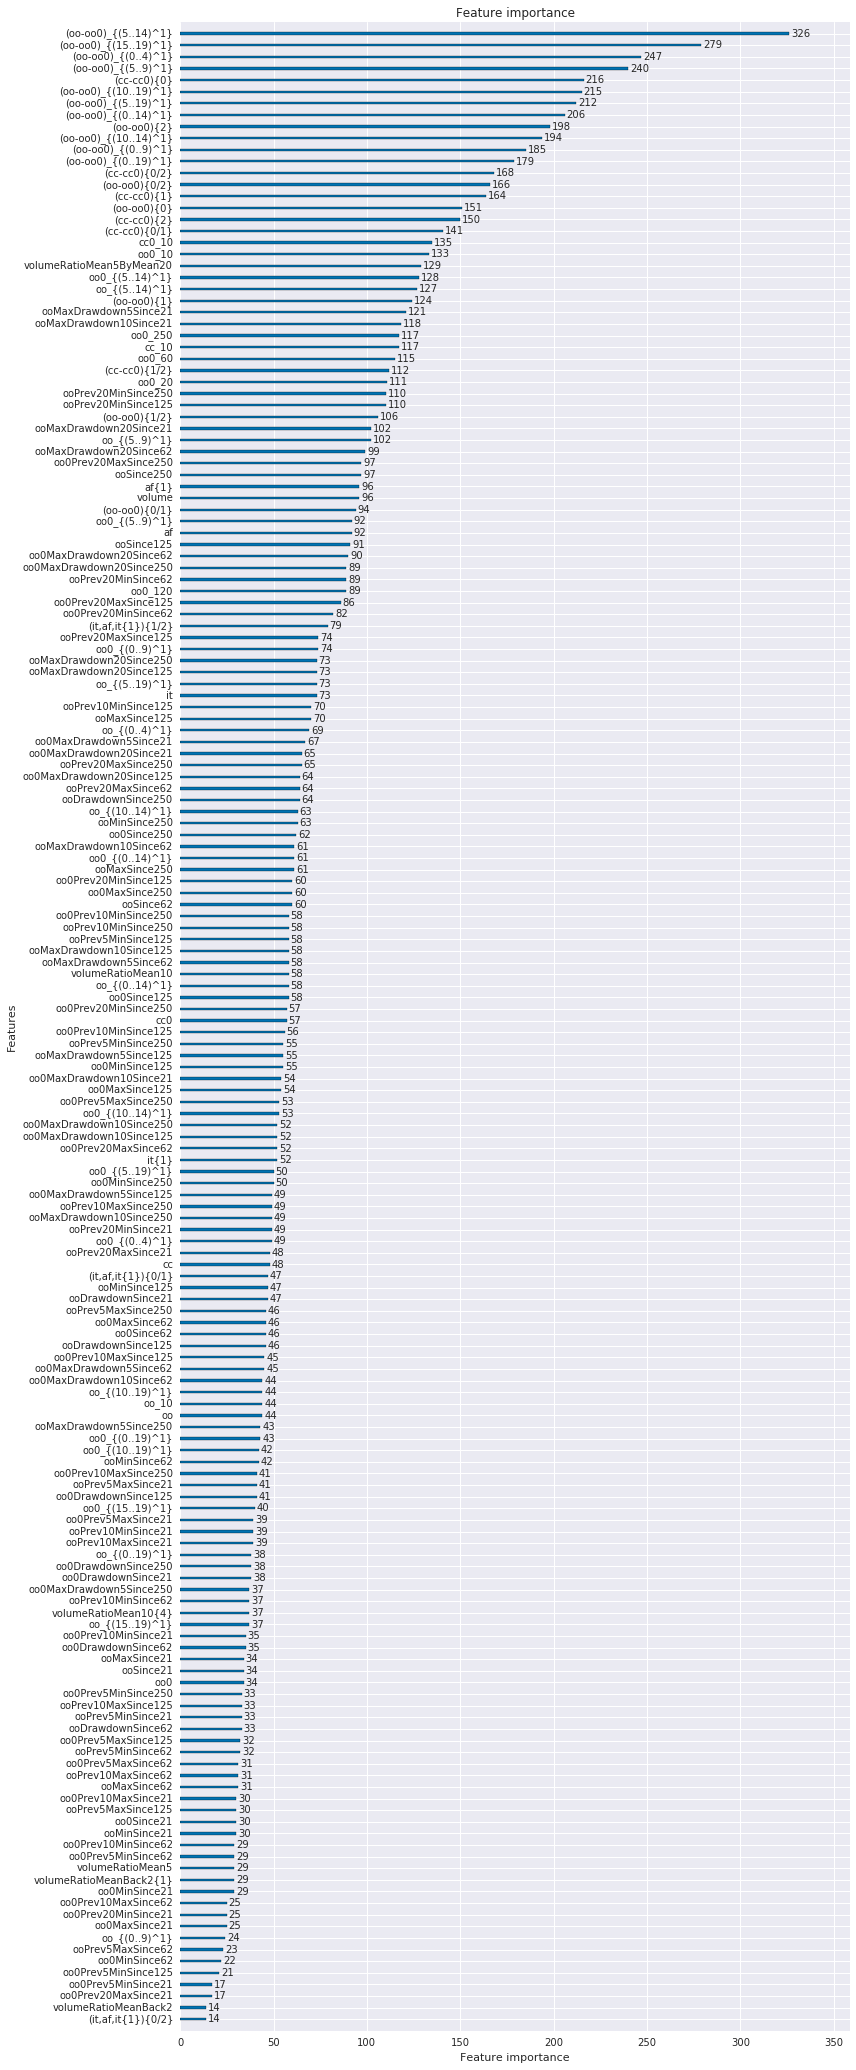

In [78]:
canvas(12,36)
print('tryfault aggressive')
lgb.plot_importance(lgb_model);
canvas(12,12)

extrafault


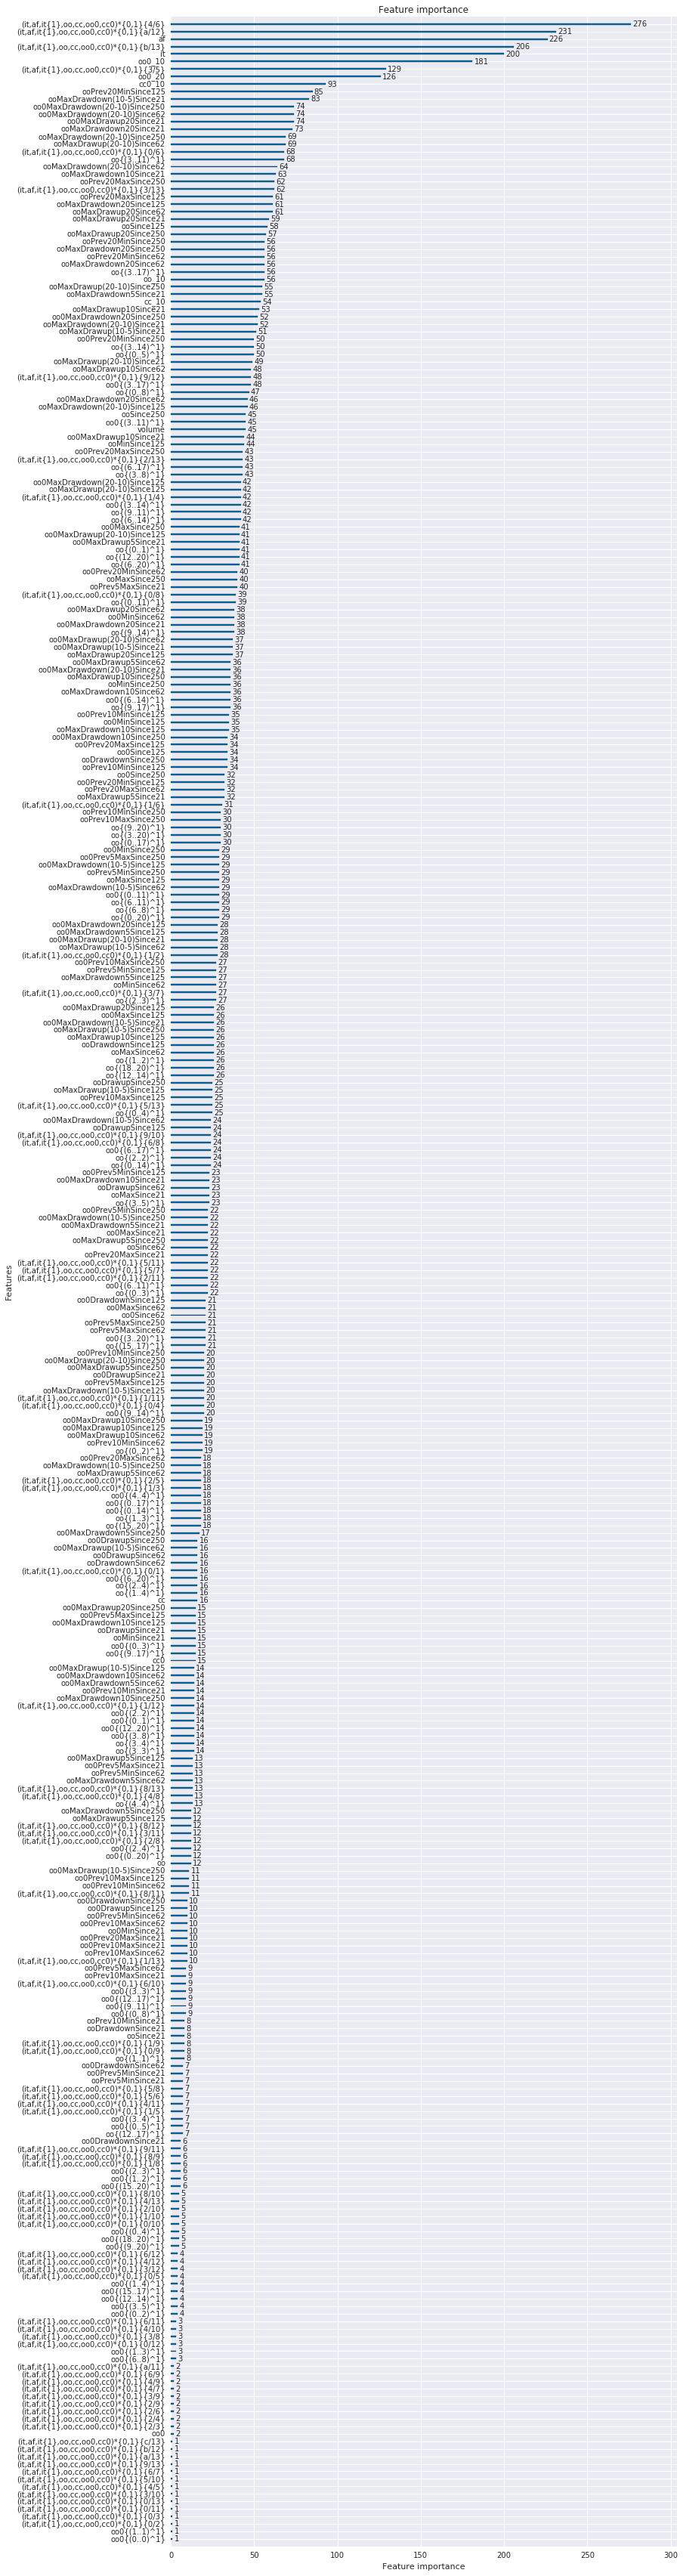

In [120]:
canvas(12,60)
print('extrafault')
lgb.plot_importance(lgb_model);
canvas(12,12)

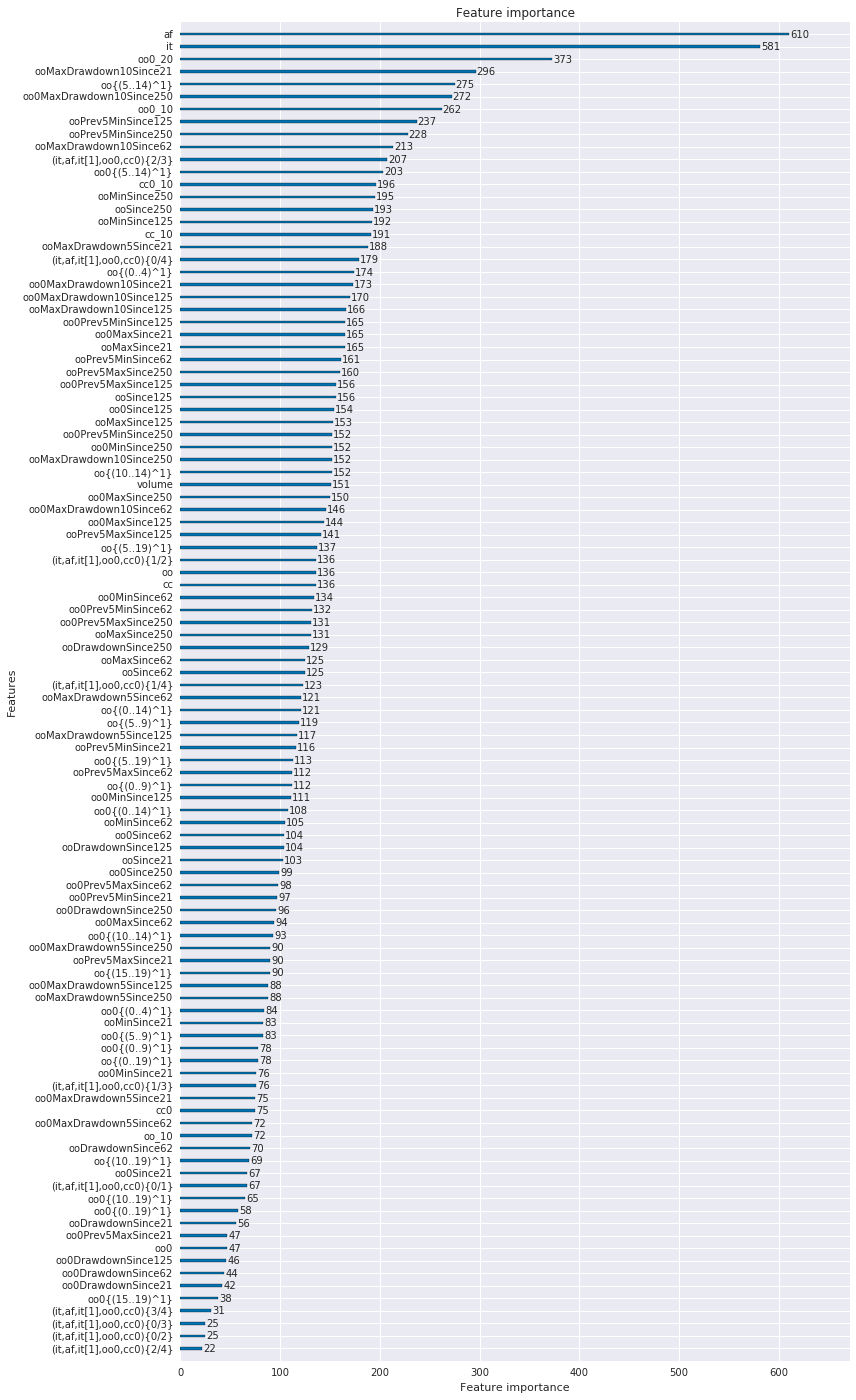

In [100]:
canvas(12,24)
# this is newfault
lgb.plot_importance(lgb_model);
canvas(12,12)

In [217]:
import shap

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(smlBst)
shap_values = explainer.shap_values(smlF_[cv])

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

NameError: name 'X' is not defined

In [225]:
with open('smlBstExplainer.pkl', 'wb') as file:
    pickle.dump((explainer,shap_values), file)

In [218]:
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], smlF_[cv].iloc[0,:])

# SCRATCH

In [53]:
f1map = {c: c for c in F1.columns}
f0map = {c: c for c in F0.columns}

In [55]:
print('{')
for c in filter(lambda c: c not in f1map, f0map):
    print('    "'+c+'": "'+c+'",')
print('}')

{
    "oo{(0..4)^1}": "oo{(0..4)^1}",
    "oo{(0..9)^1}": "oo{(0..9)^1}",
    "oo{(0..14)^1}": "oo{(0..14)^1}",
    "oo{(0..19)^1}": "oo{(0..19)^1}",
    "oo{(5..9)^1}": "oo{(5..9)^1}",
    "oo{(5..14)^1}": "oo{(5..14)^1}",
    "oo{(5..19)^1}": "oo{(5..19)^1}",
    "oo{(10..14)^1}": "oo{(10..14)^1}",
    "oo{(10..19)^1}": "oo{(10..19)^1}",
    "oo{(15..19)^1}": "oo{(15..19)^1}",
    "oo0{(0..4)^1}": "oo0{(0..4)^1}",
    "oo0{(0..9)^1}": "oo0{(0..9)^1}",
    "oo0{(0..14)^1}": "oo0{(0..14)^1}",
    "oo0{(0..19)^1}": "oo0{(0..19)^1}",
    "oo0{(5..9)^1}": "oo0{(5..9)^1}",
    "oo0{(5..14)^1}": "oo0{(5..14)^1}",
    "oo0{(5..19)^1}": "oo0{(5..19)^1}",
    "oo0{(10..14)^1}": "oo0{(10..14)^1}",
    "oo0{(10..19)^1}": "oo0{(10..19)^1}",
    "oo0{(15..19)^1}": "oo0{(15..19)^1}",
    "(it,af,it[1],oo0,cc0){0/1}": "(it,af,it[1],oo0,cc0){0/1}",
    "(it,af,it[1],oo0,cc0){0/2}": "(it,af,it[1],oo0,cc0){0/2}",
    "(it,af,it[1],oo0,cc0){0/3}": "(it,af,it[1],oo0,cc0){0/3}",
    "(it,af,it[1],oo0,cc0)

In [14]:
fmap = {f: str(f) for f in F0.columns}
fmap.update({
    "oo{(0..4)^1}": "oo_{(0..4)^1}",
    "oo{(0..9)^1}": "oo_{(0..9)^1}",
    "oo{(0..14)^1}": "oo_{(0..14)^1}",
    "oo{(0..19)^1}": "oo_{(0..19)^1}",
    "oo{(5..9)^1}": "oo_{(5..9)^1}",
    "oo{(5..14)^1}": "oo_{(5..14)^1}",
    "oo{(5..19)^1}": "oo_{(5..19)^1}",
    "oo{(10..14)^1}": "oo_{(10..14)^1}",
    "oo{(10..19)^1}": "oo_{(10..19)^1}",
    "oo{(15..19)^1}": "oo_{(15..19)^1}",
    "oo0{(0..4)^1}": "oo0_{(0..4)^1}",
    "oo0{(0..9)^1}": "oo0_{(0..9)^1}",
    "oo0{(0..14)^1}": "oo0_{(0..14)^1}",
    "oo0{(0..19)^1}": "oo0_{(0..19)^1}",
    "oo0{(5..9)^1}": "oo0_{(5..9)^1}",
    "oo0{(5..14)^1}": "oo0_{(5..14)^1}",
    "oo0{(5..19)^1}": "oo0_{(5..19)^1}",
    "oo0{(10..14)^1}": "oo0_{(10..14)^1}",
    "oo0{(10..19)^1}": "oo0_{(10..19)^1}",
    "oo0{(15..19)^1}": "oo0_{(15..19)^1}",
    "(it,af,it[1],oo0,cc0){0/1}": "(it,af,it{1},oo0,cc0){0/1}",
    "(it,af,it[1],oo0,cc0){0/2}": "(it,af,it{1},oo0,cc0){0/2}",
    "(it,af,it[1],oo0,cc0){0/3}": "(it,af,it{1},oo0,cc0){0/3}",
    "(it,af,it[1],oo0,cc0){0/4}": "(it,af,it{1},oo0,cc0){0/4}",
    "(it,af,it[1],oo0,cc0){1/2}": "(it,af,it{1},oo0,cc0){1/2}",
    "(it,af,it[1],oo0,cc0){1/3}": "(it,af,it{1},oo0,cc0){1/3}",
    "(it,af,it[1],oo0,cc0){1/4}": "(it,af,it{1},oo0,cc0){1/4}",
    "(it,af,it[1],oo0,cc0){2/3}": "(it,af,it{1},oo0,cc0){2/3}",
    "(it,af,it[1],oo0,cc0){2/4}": "(it,af,it{1},oo0,cc0){2/4}",
    "(it,af,it[1],oo0,cc0){3/4}": "(it,af,it{1},oo0,cc0){3/4}",
    "oo0Prev5MaxSince21": "oo0Prev10MaxSince21",
    "oo0Prev5MaxSince62": "oo0Prev10MaxSince62",
    "oo0Prev5MaxSince125": "oo0Prev10MaxSince125",
    "oo0Prev5MaxSince250": "oo0Prev10MaxSince250",
    "ooPrev5MaxSince21": "ooPrev10MaxSince21",
    "ooPrev5MaxSince62": "ooPrev10MaxSince62",
    "ooPrev5MaxSince125": "ooPrev10MaxSince125",
    "ooPrev5MaxSince250": "ooPrev10MaxSince250",
    "oo0Prev5MinSince21": "oo0Prev10MinSince21",
    "oo0Prev5MinSince62": "oo0Prev10MinSince62",
    "oo0Prev5MinSince125": "oo0Prev10MinSince125",
    "oo0Prev5MinSince250": "oo0Prev10MinSince250",
    "ooPrev5MinSince21": "ooPrev10MinSince21",
    "ooPrev5MinSince62": "ooPrev10MinSince62",
    "ooPrev5MinSince125": "ooPrev10MinSince125",
    "ooPrev5MinSince250": "ooPrev10MinSince250",
    "oo0_20": None
})

In [17]:
gc.collect()
#df1 = F1[fNewfault]
df0 = F0.copy()
df0.columns = [fmap[f] for f in df0.columns]
df0.drop(columns=[None], inplace=True)
df01 = df0[fNewfault]
#eq = df0.fillna(np.inf)==df1.fillna(np.inf)

In [18]:
set(df0.columns)-set(df01.columns)

{'(it,af,it{1},oo0,cc0){0/1}',
 '(it,af,it{1},oo0,cc0){0/2}',
 '(it,af,it{1},oo0,cc0){0/3}',
 '(it,af,it{1},oo0,cc0){0/4}',
 '(it,af,it{1},oo0,cc0){1/2}',
 '(it,af,it{1},oo0,cc0){1/3}',
 '(it,af,it{1},oo0,cc0){1/4}',
 '(it,af,it{1},oo0,cc0){2/3}',
 '(it,af,it{1},oo0,cc0){2/4}',
 'af',
 'it'}

In [39]:
#pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)

In [137]:
eq.sum(axis=0)/len(eq)

volume                        1.0
close                         1.0
open                          1.0
assetCodeId                   1.0
assetNameId                   1.0
cc                            1.0
oo                            1.0
cc0                           1.0
oo0                           1.0
cc_10                         1.0
oo_10                         1.0
cc0_10                        1.0
oo0_10                        1.0
dayOfYear                     1.0
dayOfWeek                     1.0
ooSince21                     1.0
ooMaxSince21                  1.0
ooDrawdownSince21             1.0
ooMaxDrawdown5Since21         1.0
ooMaxDrawdown10Since21        1.0
ooPrev10MaxSince21            1.0
ooMinSince21                  1.0
ooPrev10MinSince21            1.0
ooSince62                     1.0
ooMaxSince62                  1.0
ooDrawdownSince62             1.0
ooMaxDrawdown5Since62         1.0
ooMaxDrawdown10Since62        1.0
ooPrev10MaxSince62            1.0
ooMinSince62  

In [143]:
F0.af.value_counts().shape

(1456,)

In [70]:
assetCodeIdMap['AAPL.O']

3

In [113]:
pd.concat([F0.af,F1.af], axis=1)[F0.assetCodeId==3].head(20).reset_index(drop=True)

,af,af
0,-0.003366,0.002691
1,-0.003366,0.025673
2,-0.003366,0.014485
3,-0.003366,-0.015383
4,-0.003366,-0.006062
5,-0.003366,0.005487
6,-0.003366,-0.001436
7,-0.003366,-0.003616
8,-0.003366,-0.016902
9,-0.003366,-0.058269


In [91]:
.136701+.008295

0.14499599999999999

In [38]:
list(F1.columns)

['volume',
 'close',
 'open',
 'assetCodeId',
 'assetNameId',
 'cc',
 'oo',
 'cc0',
 'oo0',
 'cc_10',
 'oo_10',
 'cc0_10',
 'oo0_10',
 'dayOfYear',
 'dayOfWeek',
 'af',
 'it',
 'ooSince21',
 'ooMaxSince21',
 'ooDrawdownSince21',
 'ooMinSince21',
 'ooDrawupSince21',
 'ooMaxDrawup5Since21',
 'ooMaxDrawup10Since21',
 'ooMaxDrawup(10-5)Since21',
 'ooMaxDrawup(20-10)Since21',
 'ooSince62',
 'ooMaxSince62',
 'ooDrawdownSince62',
 'ooMinSince62',
 'ooDrawupSince62',
 'ooMaxDrawup5Since62',
 'ooMaxDrawup10Since62',
 'ooMaxDrawup(10-5)Since62',
 'ooMaxDrawup(20-10)Since62',
 'ooSince125',
 'ooMaxSince125',
 'ooDrawdownSince125',
 'ooMinSince125',
 'ooDrawupSince125',
 'ooMaxDrawup5Since125',
 'ooMaxDrawup10Since125',
 'ooMaxDrawup(10-5)Since125',
 'ooMaxDrawup(20-10)Since125',
 'ooSince250',
 'ooMaxSince250',
 'ooDrawdownSince250',
 'ooMinSince250',
 'ooDrawupSince250',
 'ooMaxDrawup5Since250',
 'ooMaxDrawup10Since250',
 'ooMaxDrawup(10-5)Since250',
 'ooMaxDrawup(20-10)Since250',
 'oo0Since21',

In [40]:
fNewfault = [str(c) for c in F0.columns if c in F1.columns]
fNewfault += [fmap[c] for c in F0.columns if c not in F1.columns]
fNewfault = [c.replace('Prev5','Prev10') for c in fNewfault]
print('["'+'","'.join(fNewfault)+'"]')

["volume","close","open","assetCodeId","assetNameId","cc","oo","cc0","oo0","cc_10","oo_10","cc0_10","oo0_10","dayOfYear","dayOfWeek","af","it","oo0_20","ooSince21","ooMaxSince21","ooDrawdownSince21","ooMaxDrawdown5Since21","ooMaxDrawdown10Since21","ooPrev10MaxSince21","ooMinSince21","ooPrev10MinSince21","ooSince62","ooMaxSince62","ooDrawdownSince62","ooMaxDrawdown5Since62","ooMaxDrawdown10Since62","ooPrev10MaxSince62","ooMinSince62","ooPrev10MinSince62","ooSince125","ooMaxSince125","ooDrawdownSince125","ooMaxDrawdown5Since125","ooMaxDrawdown10Since125","ooPrev10MaxSince125","ooMinSince125","ooPrev10MinSince125","ooSince250","ooMaxSince250","ooDrawdownSince250","ooMaxDrawdown5Since250","ooMaxDrawdown10Since250","ooPrev10MaxSince250","ooMinSince250","ooPrev10MinSince250","oo0Since21","oo0MaxSince21","oo0DrawdownSince21","oo0MaxDrawdown5Since21","oo0MaxDrawdown10Since21","oo0Prev10MaxSince21","oo0MinSince21","oo0Prev10MinSince21","oo0Since62","oo0MaxSince62","oo0DrawdownSince62","oo0MaxDr

In [97]:
F0.ooMinSince250.tail()

4072951   -0.577589
4072952   -0.358571
4072953   -0.367725
4072954   -0.030943
4072955   -0.195699
Name: ooMinSince250, dtype: float64

In [99]:
F1.ooPrev5MinSince250.tail()

4072951   -0.577589
4072952   -0.358571
4072953   -0.367725
4072954   -0.011788
4072955   -0.195699
Name: ooPrev5MinSince250, dtype: float64

In [36]:
gc.collect()
df1 = FF[fSelection]
df0 = F1[fSelection]
eq = df0.fillna(np.inf)==df1.fillna(np.inf)

In [40]:
guy = pd.DataFrame(index=FF[FF.assetCodeId==3].index)
guy['FF'] = FF['af'][FF.assetCodeId==3]
guy['F1'] = F1['af'][F1.assetCodeId==3]
guy['diff'] = guy.FF-guy.F1
guy

,FF,F1,diff
732815,0.002691,0.002691,0.0
734404,0.025673,0.025673,0.0
735994,0.014485,0.014485,0.0
737587,-0.015383,-0.015383,0.0
739182,-0.006062,-0.006062,0.0
740777,0.005487,0.005487,0.0
742373,-0.001436,-0.001436,0.0
743970,-0.003616,-0.003616,0.0
745564,-0.016902,-0.016902,0.0
747159,-0.058269,-0.058269,0.0


In [41]:
eq.sum(axis=0)/len(eq)

volume                                    1.0
cc                                        1.0
oo                                        1.0
cc0                                       1.0
oo0                                       1.0
cc_10                                     1.0
oo_10                                     1.0
cc0_10                                    1.0
oo0_10                                    1.0
af                                        1.0
it                                        1.0
ooSince21                                 1.0
ooMaxSince21                              1.0
ooDrawdownSince21                         1.0
ooMinSince21                              1.0
ooDrawupSince21                           1.0
ooMaxDrawup5Since21                       1.0
ooMaxDrawup10Since21                      1.0
ooMaxDrawup(10-5)Since21                  1.0
ooMaxDrawup(20-10)Since21                 1.0
ooSince62                                 1.0
ooMaxSince62                      

In [43]:
a = O(i=0)
b = O(i=555)

In [59]:
for i in range(2500):
    o = a
    m = test[o.i][0]
    add_basic_features(M=m)
    m = m[~m.assetCode.isna()]
    assetCodeIndexedDf.join(m.set_index('assetCode'))
    #w = m.pivot('time','assetCode')
    if i%100==0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400


KeyboardInterrupt: 

In [61]:
guy = assetCodeIndexedDf.join(m.set_index('assetCode'))

In [12]:
{4:5}(({5:7}))

AttributeError: 'dict' object has no attribute 'extend'

In [28]:
for i in range(len(test)):
    assert (test[0][0].assetCode==test[0][2].assetCode).all()

In [34]:
pd.DataFrame([np.asarray([5,6,7]),np.asarray([2,0,9])],columns=[0,1,2],index=['one','two']).T[...]

KeyError: Ellipsis

In [53]:
guy = test[0][2].copy()
guy.index = test[0][2].assetCode.astype(assetCodeCategorical)
guy = guy[~guy.index.isna()]
guyguy = test[100][2].copy()
guyguy.index = test[100][2].assetCode.astype(assetCodeCategorical)
guyguy = guyguy[~guyguy.index.isna()]
print(lens(guy,guyguy))
pd.concat([guyguy,guy],axis=0).index.isna().any()

(1821, 1774)


False

In [59]:
guy

,assetCode,confidenceValue
assetCode,,
A.N,A.N,0.0
AA.N,AA.N,0.0
AAL.O,AAL.O,0.0
AAN.N,AAN.N,0.0
AAP.N,AAP.N,0.0
AAPL.O,AAPL.O,0.0
ABB.N,ABB.N,0.0
ABBV.N,ABBV.N,0.0
ABC.N,ABC.N,0.0


In [58]:
test[100][2].reset_index()

,index,assetCode,confidenceValue
0,0,A.N,0.0
1,1,AA.N,0.0
2,2,AAL.O,0.0
3,3,AAN.N,0.0
4,4,AAOI.O,0.0
5,5,AAP.N,0.0
6,6,AAPL.O,0.0
7,7,AAT.N,0.0
8,8,AAXN.O,0.0
9,9,ABB.N,0.0


dict_keys([{.assetName}, {.volume}, {.close}, {.open}, {.returnsClosePrevRaw1}, {.returnsOpenPrevRaw1}, {.returnsClosePrevMktres1}, {.returnsOpenPrevMktres1}, {.returnsClosePrevRaw10}, {.returnsOpenPrevRaw10}, {.returnsClosePrevMktres10}, {.returnsOpenPrevMktres10}, {.returnsOpenNextMktres10}, {.universe}, {.cc}, {.oo}, {.cc0}, {.oo0}, {.cc_10}, {.oo_10}, {.cc0_10}, {.oo0_10}, {.pseudo_target}, {.assetName_}, {.volume_}, {.close_}, {.open_}, {.returnsClosePrevRaw1_}, {.returnsOpenPrevRaw1_}, {.returnsClosePrevMktres1_}, {.returnsOpenPrevMktres1_}, {.returnsClosePrevRaw10_}, {.returnsOpenPrevRaw10_}, {.returnsClosePrevMktres10_}, {.returnsOpenPrevMktres10_}, {.returnsOpenNextMktres10_}, {.universe_}, {.cc_}, {.oo_}, {.cc0_}, {.oo0_}, {.cc_10_}, {.oo_10_}, {.cc0_10_}, {.oo0_10_}, {.pseudo_target_}, {.df}, {.af}, {.it}, 'oo{01/}', 'oo{0123/}', 'oo{012345/}', 'oo{01234567/}', 'oo{0123456789/}', 'oo{23/}', 'oo{2345/}', 'oo{234567/}', 'oo{23456789/}', 'oo{45/}', 'oo{4567/}', 'oo{456789/}', '

In [81]:
M.head()[[]]

""
0
1
2
3
4
